In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [ ]:
!pip install --quiet pytorch_lightning 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import pytorch_lightning
from torchvision import transforms
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable

from datetime import datetime
import time
import math

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Training')
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N', # 1 for test, 10 for train
                    help='number of epochs to train')
parser.add_argument('--num-classes', default=10,
                    help='number of classes in the input dataset')
#parser.add_argument('--lr', type=float, default=0.0002, metavar='LR',
#                    help='learning rate')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                     help='learning rate')  # cascade version, original = 0.01
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--random', default=True,
                    help='random initialization for PGD')
# FGSM: num-steps:1 step-size:0.1099   PGD-20: num-steps:20 step-size:0.005495
parser.add_argument('--epsilon', default=0.1099, # matters for region
                    help='perturbation')
parser.add_argument('--num-steps', default=20,
                    help='perturb number of steps, FGSM: 1, PGD-20: 20')
parser.add_argument('--step-size', default=0.005495,
                    help='perturb step size, FGSM: 0.1099, PGD-20: 0.005495') # change from 0.1099 to 0.005495 3/12/2021

args = parser.parse_args(args=[])
# Device setup
if args.no_cuda:
	device = torch.device("cpu")
else:
	device = torch.device("cuda:0")

In [ ]:
print(device)

cuda:0


In [ ]:
# MNIST data
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(test_set, batch_size=args.batch_size,  shuffle=False, drop_last=True)

train_data, val_data = torch.utils.data.random_split(train_set, [42000, 18000])

train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=False, drop_last=True)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
import pickle

# Attack model

In [ ]:
class Fnn(nn.Module):
	def __init__(self):
		super(Fnn, self).__init__()
		self.fc1 = nn.Linear(28*28, 128)
		self.fc2 = nn.Linear(128, 64)
		self.fc3 = nn.Linear(64, 32)
		self.fc4 = nn.Linear(32, 10)
	
	def forward(self, x):
		x = self.fc1(x)
		x = F.relu(x)
		x = self.fc2(x)
		x = F.relu(x)
		x = self.fc3(x)
		x = F.relu(x)
		x = self.fc4(x)
		x = F.relu(x)
		x = F.log_softmax(x, dim=1)
		return x

In [ ]:
from IPython.utils.path import target_update
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), 28 * 28)

        # clear gradients
        optimizer.zero_grad()

        #print(model(data).shape, target.shape)
        #print(model(data).dtype, target.dtype)
        loss = F.cross_entropy(model(data), target)

        # get gradients and update
        loss.backward()
        optimizer.step()

In [ ]:
def eval_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    idx = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), 28 * 28)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            idx += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
def train_fnn(model):
	model = model.to(device)
 
	for epoch in range(1, args.epochs+1):
		start_time = time.time()
		sgd = optim.SGD(model.parameters(), lr=args.lr)
  
		train(args, model, device, train_loader, sgd, epoch)

		trnloss, trnacc = eval_test(model, device, train_loader)

		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', end=', ')
		print('trn_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')

	return model

In [ ]:
#fnn = train_fnn(Fnn())

In [ ]:
#torch.save(fnn.state_dict(), "./"+'fnn'+'.pt')

In [ ]:
fnn = Fnn().to(device)

In [ ]:
fnn.load_state_dict(torch.load('fnn.pt'))

<All keys matched successfully>

In [ ]:
fnn.eval()

Fnn(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
# trnloss, trnacc = eval_test(fnn, device, test_loader)
# print('test_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')



---



In [ ]:
!pip install --quiet captum

In [ ]:
import matplotlib.pyplot as plt

# XAI label

In [ ]:
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=False, drop_last=True)

In [ ]:
# from copy import deepcopy
from captum.attr import IntegratedGradients

In [ ]:
# saliency = IntegratedGradients(fnn)

# label = []
# sample = train_set[0]

# for data, target in train_loader:
#   #print(target)
#   data, target = data.to(device), target.to(device)
#   data = data.view(data.size(0), 28 * 28)
#   attribution = saliency.attribute(data, target=target)
#   label.append(attribution)

In [ ]:
# with open("label512", "wb") as fp:
#   pickle.dump(label, fp)

In [ ]:
with open("/content/drive/MyDrive/FYP/label512", "rb") as fp:
  label = pickle.load(fp)

In [ ]:
print(torch.max(label[0]))

tensor(0.4399, device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.min(label[0]))

tensor(-0.5735, device='cuda:0', dtype=torch.float64)


In [ ]:
# plt.imshow(sample[0].cpu().detach().numpy().reshape((28,28)), cmap='gray')

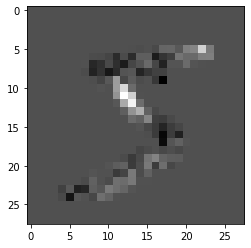

In [ ]:
plt.imshow(label[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# cifar

In [ ]:
# CIFAR-10 data
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(train_set, batch_size=args.batch_size,  shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        #x = x.reshape(1,3,512,1024)
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
def eval_testX(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    idx = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            idx += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
alex = AlexNet().to(device)

In [ ]:
def train_alex(model):
	model = model.to(device)
 
	for epoch in range(1, args.epochs+1):
		start_time = time.time()
		sgd = optim.SGD(model.parameters(), lr=args.lr)
  
		trainX(args, model, device, train_loader, sgd, epoch)

		trnloss, trnacc = eval_testX(model, device, train_loader)

		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', end=', ')
		print('trn_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')

	return model

In [ ]:
from IPython.utils.path import target_update
def trainX(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # clear gradients
        optimizer.zero_grad()

        loss = F.cross_entropy(model(data), target)

        # get gradients and update
        loss.backward()
        optimizer.step()

In [ ]:
alex = train_alex(alex)
alex.eval()

Epoch 1: 14s, trn_loss: 1.2315, trn_acc: 54.88%
Epoch 2: 13s, trn_loss: 1.1831, trn_acc: 56.20%
Epoch 3: 13s, trn_loss: 1.0706, trn_acc: 61.89%
Epoch 4: 13s, trn_loss: 1.0515, trn_acc: 62.02%
Epoch 5: 15s, trn_loss: 0.9748, trn_acc: 65.10%
Epoch 6: 14s, trn_loss: 0.8088, trn_acc: 70.88%
Epoch 7: 14s, trn_loss: 0.7561, trn_acc: 73.15%
Epoch 8: 13s, trn_loss: 0.6585, trn_acc: 76.39%
Epoch 9: 13s, trn_loss: 0.5770, trn_acc: 79.85%
Epoch 10: 13s, trn_loss: 0.4737, trn_acc: 83.32%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
#torch.save(alex.state_dict(), "/content/drive/MyDrive/FYP/alex3.3.pt")

In [ ]:
#alex.load_state_dict(torch.load('/content/drive/MyDrive/FYP/alex3.3.pt'))

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
saliency = IntegratedGradients(alex)

label = []
sample = train_set[0]

for data, target in train_loader:
  #print(target)
  data, target = data.to(device), target.to(device)
  attribution = saliency.attribute(data, target=target)
  label.append(attribution)

In [ ]:
from captum.attr import LRP

In [ ]:
lrpa = LRP(alex)

lrp = []

for data, target in train_loader:
  data, target = data.to(device), target.to(device)
  attribution = lrpa.attribute(data, target=target)
  lrp.append(attribution)

In [ ]:
import random

In [ ]:
def mute(a=.5, b=.5, thr=.5):
  """
  random mutation on weight
  """
  rand = random.random()
  a = rand
  b = 1-a
  if rand<thr:
    #print('mute')
    a = 1-a
    b = 1-b
  #print('a:', a, 'b:', b)
  return (a,b)

lbl = []

#importance mask
for i in range(len(lrp)):
  a, b = mute()
  with torch.no_grad():
    lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
	# print(X_pgd.shape)
	# region = Variable(region.data, requires_grad=True)
 
	if args.random:
		#noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device) 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			#print('m',model(X_pgd).shape)
			#print('y',y.shape)
			loss = F.cross_entropy(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		#print('r', region.shape)
		# print(region.grad.data)

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
def pgd_eval_adv_test(device, test_loader):

    alex.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            print(batch_idx)
            data, target = data.to(device), target.to(device)

            #data = data.view(data.size(0), 28 * 28)
            adv_data = pgd_whitebox0(batch_idx, alex, data, target, device=device)

            output = alex(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0
pgd time:  0.0740058422088623  s
0 misclassified: 128
1
pgd time:  0.07313895225524902  s
1 misclassified: 128
2
pgd time:  0.07216286659240723  s
2 misclassified: 128
3
pgd time:  0.07108163833618164  s
3 misclassified: 128
4
pgd time:  0.07707738876342773  s
4 misclassified: 128
5
pgd time:  0.063079833984375  s
5 misclassified: 128
6
pgd time:  0.0689699649810791  s
6 misclassified: 128
7
pgd time:  0.07559514045715332  s
7 misclassified: 128
8
pgd time:  0.07203960418701172  s
8 misclassified: 128
9
pgd time:  0.06635022163391113  s
9 misclassified: 128
10
pgd time:  0.06483721733093262  s
10 misclassified: 128
11
pgd time:  0.06479144096374512  s
11 misclassified: 128
12
pgd time:  0.0659031867980957  s
12 misclassified: 128
13
pgd time:  0.07537841796875  s
13 misclassified: 128
14
pgd time:  0.07531619071960449  s
14 misclassified: 128
15
pgd time:  0.0766599178314209  s
15 misclassified: 128
16
pgd time:  0.0741569995880127  s
16 misclassified: 128
17
pgd time:  0.07566380500

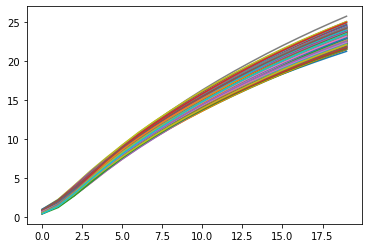

In [ ]:
advloss, advacc = pgd_eval_adv_test(device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
def lbl_eval_adv_test(mask, device, test_loader):

    alex.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            #data = data.view(data.size(0), 28*28)
            adv_data = pgd_whitebox(batch_idx, alex, data, mask[batch_idx].to(torch.float32), target, device=device)

            #adv_data = adv_data.view(adv_data.size(0), 28*28)
            output = alex(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

pgd time:  0.07132387161254883  s
0 misclassified: 128
pgd time:  0.06983757019042969  s
1 misclassified: 128
pgd time:  0.0670461654663086  s
2 misclassified: 128
pgd time:  0.0647878646850586  s
3 misclassified: 128
pgd time:  0.07103657722473145  s
4 misclassified: 128
pgd time:  0.07095217704772949  s
5 misclassified: 128
pgd time:  0.0713036060333252  s
6 misclassified: 128
pgd time:  0.07029891014099121  s
7 misclassified: 128
pgd time:  0.07196903228759766  s
8 misclassified: 128
pgd time:  0.0699467658996582  s
9 misclassified: 128
pgd time:  0.07049918174743652  s
10 misclassified: 128
pgd time:  0.07120299339294434  s
11 misclassified: 128
pgd time:  0.06980156898498535  s
12 misclassified: 128
pgd time:  0.07007265090942383  s
13 misclassified: 128
pgd time:  0.0758063793182373  s
14 misclassified: 128
pgd time:  0.07057046890258789  s
15 misclassified: 128
pgd time:  0.0629415512084961  s
16 misclassified: 128
pgd time:  0.06264996528625488  s
17 misclassified: 128
pgd time

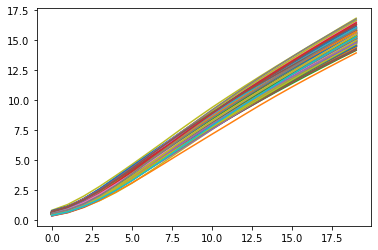

In [ ]:
advloss, advacc = lbl_eval_adv_test(lbl, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
saliency = IntegratedGradients(alex)

audit1 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox0(idx+1, alex, data, target)
  attribution = saliency.attribute(adv_data, target=target)
  audit1.append(attribution)

In [ ]:
saliency = IntegratedGradients(fnn)

audit2 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox(idx+1, fnn, data, mask[idx], target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit2.append(attribution)

In [ ]:
#@title XAI(data vs PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit1[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8745, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


# CIFAR benchmark

In [ ]:
!pip install --quiet torchattacks

In [ ]:
import torchattacks

In [ ]:
atk = torchattacks.SparseFool(alex)
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
      data, target = data.to(device), target.to(device)
      atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
      adv_data = atk(data, target)
      saliency = IntegratedGradients(alex)
      audit1 = saliency.attribute(adv_data, target=target)

- Save progress: 100.00 % / Robust accuracy: 11.72 % / L2: 0.00000 (347.498 it/s) 	


In [ ]:
#@title XAI Monitor(data vs SparseFool)
sim = nn.CosineSimilarity()(label[0], audit1)
sim = torch.nan_to_num(sim)
print(torch.mean(sim))

tensor(0.8917, device='cuda:0', dtype=torch.float64)


In [ ]:
atk = torchattacks.SINIFGSM(alex, steps=20)
audit1 = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
    adv_data = atk(data, target)
    saliency = IntegratedGradients(alex)
    audit1.append(saliency.attribute(adv_data, target=target))

- Save progress: 100.00 % / Robust accuracy: 11.72 % / L2: 1.66370 (0.988 it/s) 	


In [ ]:
#@title XAI Monitor(data vs SINIFGSM)
sim = nn.CosineSimilarity()(label[0], audit1)
sim = torch.nan_to_num(sim)
print(torch.mean(sim))

tensor(0.6571, device='cuda:0', dtype=torch.float64)


torch.Size([3, 32, 32])


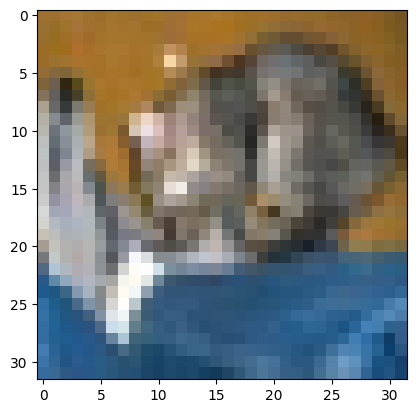

In [ ]:
#@title Sample
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
    print(data[0].shape)
    plt.imshow(transforms.ToPILImage()(data[0]))

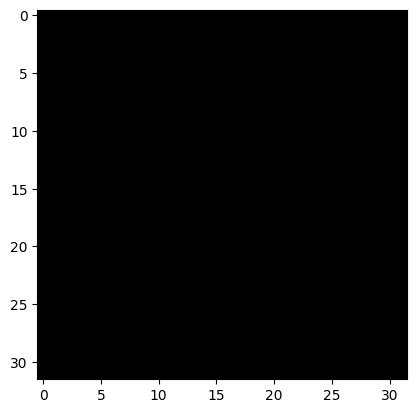

In [ ]:
plt.imshow(audit1[0].cpu().detach().numpy().reshape(32,32,3))

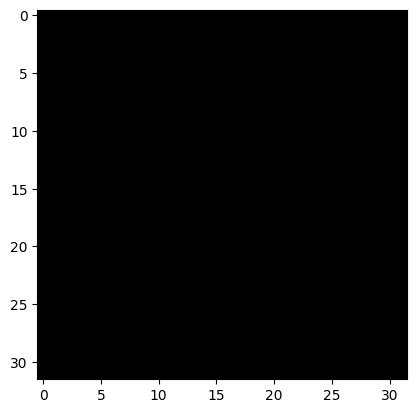

In [ ]:
plt.imshow(transforms.ToPILImage()(audit1[0]))

# No need to train

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_steps=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
	# print(X_pgd.shape)
	# region = Variable(region.data, requires_grad=True)
 
	if args.random:
		#noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device) 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			#print('m',model(X_pgd).shape)
			#print('y',y.shape)
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()
		#print('r', region.shape)
		# print(region.grad.data)

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	#print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	#print('pgd time: ', et-st, ' s')
	#st = [i for i in range(20)]
	#plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
iters = len(train_loader)

In [ ]:
def joint_train(args, model, device, train_loader, optimizer, epoch, scheduler):
	k1 = 5
	k2 = 1
	lb = lbl
	model.train()
	l1loss = nn.MSELoss()

	for batch_idx, (data, target) in enumerate(train_loader):
		data = data.to(device)
		target = target.to(device)   

		optimizer.zero_grad()

		# self loss itr 2
		mask = model(data)
		loss = k2*l1loss(pgd_whitebox(batch_idx, fnn, data, mask, target, device=device),
				data.requires_grad \
				+ k1*l1loss(mask, lbl[batch_idx])

		#loss.requires_grad = True
		loss.backward()
		optimizer.step()
		scheduler.step(epoch + batch_idx / iters)

In [ ]:
from datetime import datetime

# Getting the current date and time
dt = datetime.now()

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
def adv(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      buf = model(data)
      adv = pgd_whitebox(idx, fnn, data, buf, target, device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def adv0(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      adv = pgd_whitebox0(idx, fnn, data, target, device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def train_model(epoch=args.epochs):
	lbd=1e-2
	
	loss_t = []
	loss_v = []
	
	k = torch.Tensor([1,1,1])
	l1loss = nn.L1Loss()
									
	model = UNet().to(device)
	
	model_name = str(datetime.now()) + '.pt'

 
	for epoch in range(1, epoch+1):
		model.train()
	
		start_time = time.time()
		optimizer = optim.SGD(model.parameters() , lr=args.lr)
		scheduler = CosineAnnealingWarmRestarts(optimizer, int(iters/2))
	
		
		lb = lbl
		
		total_l_t = 0.0
		total_l_v = 0.0

		for batch_idx, (data, target) in enumerate(train_loader):
			data = data.to(device)
			target = target.to(device)   

			optimizer.zero_grad()

			# self loss itr 2
			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data, mask, target, device=device), 
			                   data.requires_grad + k[1]*l1loss(mask, lbl[batch_idx]) + k[2]*(
								         adv(model, batch_idx, data, target)-adv0(model, batch_idx, \
												 data, target))

			loss.retain_grad()
			loss /= args.batch_size
			loss.backward()
	 
			loss += lbd*loss.grad
			
			
			total_l_t += loss.item()
	 
			
			optimizer.step()
			scheduler.step(epoch + batch_idx / iters)

		loss_t.append(total_l_t/len(train_loader))
	
		for batch_idx, (data, target) in enumerate(val_loader):
			model.eval()
			data = data.to(device)
			target = target.to(device) 

			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data, mask, target, device=device), 
			                   data.requires_grad + k[1]*l1loss(mask, lbl[batch_idx]) + k[2]*(
										     adv(model, batch_idx, data, target)-adv0(model, batch_idx, data, 
												 target))
			total_l_v += loss.item()
	 
		loss_v.append(total_l_v/len(val_loader))
	 
		# early_stopping(loss_v[0], model)
	
		# if early_stopping.early_stop:
		# 	print("Early stopping")
		# 	break
		
		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', \
		      'val loss', float(loss_v[-1]))
	
	torch.save(model.state_dict(), "/content/drive/MyDrive/FYP/"+'ua'+str(loss_v[-1])+'.pt')

	return model

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
umodel = train_model(10) # the net

# V2

In [ ]:
from captum.attr import GuidedBackprop

In [ ]:
# GB = GuidedBackprop(fnn)

# mask = []

# for data, target in train_loader:
#   data, target = data.to(device), target.to(device)
#   data = data.view(data.size(0), 28 * 28)
#   attribution = GB.attribute(data, target=target)
#   mask.append(attribution)

In [ ]:
# with open("/content/drive/MyDrive/FYP/mask512", "wb") as fp:
#   pickle.dump(mask, fp)

In [ ]:
with open("/content/drive/MyDrive/FYP/mask512", "rb") as fp:
  mask = pickle.load(fp)

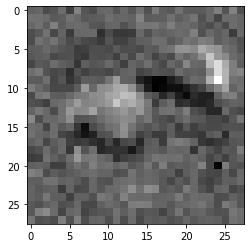

In [ ]:
plt.imshow(mask[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')



---



In [ ]:
from captum.attr import LRP

In [ ]:
# lrpa = LRP(fnn)

# lrp = []

# for data, target in train_loader:
#   data, target = data.to(device), target.to(device)
#   data = data.view(data.size(0), 28 * 28)
#   attribution = lrpa.attribute(data, target=target)
#   lrp.append(attribution)

In [ ]:
# with open("/content/drive/MyDrive/FYP/lrp512", "wb") as fp:
#   pickle.dump(lrp, fp)

In [ ]:
with open("/content/drive/MyDrive/FYP/lrp512", "rb") as fp:
  lrp = pickle.load(fp)

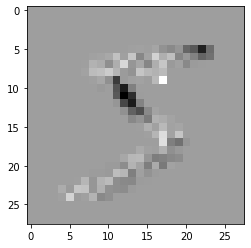

In [ ]:
plt.imshow(lrp[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
print(torch.max(lrp[0]))

tensor(47.9546, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
print(torch.min(lrp[0]))

tensor(-59.2969, device='cuda:0', grad_fn=<MinBackward1>)


In [ ]:
import random

In [ ]:
def mute(a=.5, b=.5, thr=.5):
  """
  random mutation on weight
  """
  rand = random.random()
  a = rand
  b = 1-a
  if rand<thr:
    #print('mute')
    a = 1-a
    b = 1-b
  #print('a:', a, 'b:', b)
  return (a,b)

lbl = []

#importance mask
for i in range(len(lrp)):
  a, b = mute()
  with torch.no_grad():
    lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

In [ ]:
print(torch.max(lbl[0]))

tensor(1.3519, device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.min(lbl[0]))

tensor(0.7257, device='cuda:0', dtype=torch.float64)


In [ ]:
print(lbl[0])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.equal(label[0][0,:], lbl[0][0,:]))

False


In [ ]:
print(torch.equal(lrp[0][0,:], lbl[0][0,:]))

False


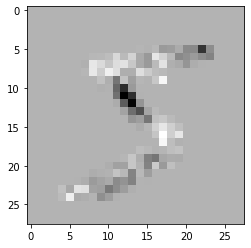

In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# Deprecated V3

In [ ]:
def gene():
  def mute(a=.5, b=.5, thr=.5):
    """
    random mutation on weight
    """
    rand = random.random()
    a = rand
    b = 1-a
    if rand<thr:
      #print('mute')
      a = 1-a
      b = 1-b
    #print('a:', a, 'b:', b)
    return (a,b)

  lbl = []

  #importance mask
  for i in range(len(lrp)):
    a, b = mute()
    with torch.no_grad():
      lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

In [ ]:
def sim(loss, t_final=100, maxIter=100, a=.5, k=.5):
	lbl = []
    T = 10
	while(T<t_final or i>=maxIter):
		gene()
        l = fit() 
        if l < loss:
            loss = l
            gene()
        else:
            d = l - loss
            r = rand()
            if (r<np.exp(-d/k*T)):
                loss = l
                gene()
        
        T = a*T
    
    return lbl

In [ ]:
def audi(x):
  saliency = IntegratedGradients(fnn)

  audit = []

  for idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    x = x.view(data.size(0), 28 * 28)
    attribution = saliency.attribute(x, target=target)
    audit.append(attribution)

  return audit

In [ ]:
def fitness(lbl, data):
  l1 = pgd_whitebox()
  l2 = pgd_whitebox0()
  a1 = audi(l1)
  a2 = audi(l2)
  return .5*(l2-l1)+.5*(a2-a1)

In [ ]:
for i in range(10):
    loss = fitness(lbl, data)

    
    # get gradients and update
    loss.backward()
    optimizer.step()
    		



---



# XAI discover attack

original data XAI

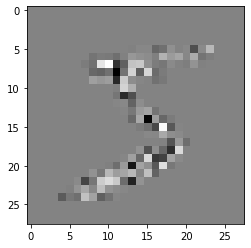

In [ ]:
plt.imshow(label[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
saliency = IntegratedGradients(fnn)

audit1 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox0(idx+1, fnn, data, target)
  attribution = saliency.attribute(adv_data, target=target)
  audit1.append(attribution)

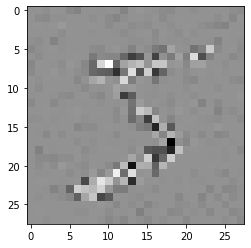

In [ ]:
plt.imshow(audit1[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
saliency = IntegratedGradients(fnn)

audit2 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox(idx+1, fnn, data, mask[idx], target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit2.append(attribution)

In [ ]:
umodel = UNet().to(device)
umodel.load_state_dict(torch.load('/content/2023-03-06 18:54:46.724925.pt'))

<All keys matched successfully>

In [ ]:
umodel.eval()

In [ ]:
saliency = IntegratedGradients(fnn)

audit2 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  #data = data.view(data.size(0), 28 * 28)
  mask = umodel(data)
  adv_data = pgd_whitebox(idx+1, fnn, data.view(data.size(0), 28 * 28), mask.view(mask.size(0), 28 * 28), target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit2.append(attribution)

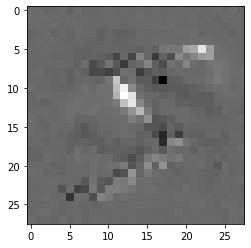

In [ ]:
plt.imshow(audit2[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
saliency = IntegratedGradients(fnn)

audit3 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox(idx+1, fnn, data, lbl[idx].to(torch.float32), target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit3.append(attribution)

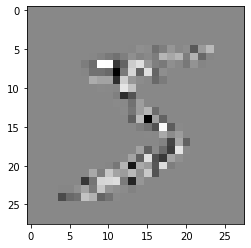

In [ ]:
plt.imshow(audit3[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
#@title XAI(data vs PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit1[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8745, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit1[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8734, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs GB PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit2[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9265, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs GB PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit2[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8388, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8384, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)




---



# Deprecated Region

In [ ]:
import matplotlib.pyplot as plt

14
3 14


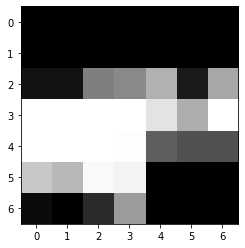

In [ ]:
rid = int(lbl[0][0].cpu())
print(rid)
x = (rid * 7) // 28
y = (rid * 7) % 28
print(x,y)
plt.imshow(train_set.data[0][x:x+7, y:y+7],cmap='gray')

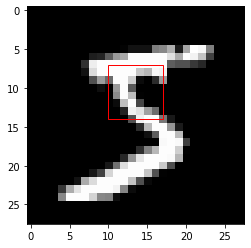

In [ ]:
plt.imshow(train_set.data[0],cmap='gray')
# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect = plt.Rectangle((x+7,y-7),7,7,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

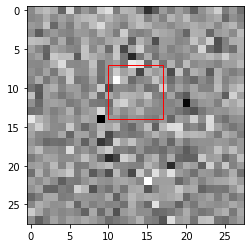

In [ ]:
plt.imshow(label[0][0,:].cpu().reshape((28,28)), cmap='gray')
# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect = plt.Rectangle((x+7,y-7),7,7,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

In [ ]:
#sum of values in window
for i in range(len(label_reg)):
  label_reg[i] = label_reg[i].sum(dim=2)
  label_reg[i] = label_reg[i].argmax(dim=1) #argmax



---



# Deprecated Model

In [ ]:
class conv_blk(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(conv_blk,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.conv(x)
    return x

In [ ]:
class up_conv(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(up_conv, self).__init__()
    self.up = nn.Sequential(
        #nn.ConvTranspose2d(ch_in, ch_in // 2, kernel_size=2, stride=2),
        nn.Upsample(scale_factor=2),
        conv_blk(ch_in, ch_out)
    )

  def forward(self, x):
    x = self.up(x)
    return x

In [ ]:
class recur_blk(nn.Module):
  def __init__(self, ch_out, t=2):
    super(recur_blk, self).__init__()
    self.t = t
    self.ch_out = ch_out
    self.conv = nn.Sequential(
        nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    for i in range(self.t):
      if not i:
        x1 = self.conv(x)
      
      x1 = self.conv(x+x1)
    
    return x1

In [ ]:
class RRCNN_blk(nn.Module):
  def __init__(self, ch_in, ch_out, t=2):
    super(RRCNN_blk, self).__init__()
    self.RCNN = nn.Sequential(
        recur_blk(ch_out, t=t),
        recur_blk(ch_out, t=t),
    )
    self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    x = self.conv(x)
    x1 = self.RCNN(x)
    return x+x1

In [ ]:
class att_blk(nn.Module):
  def __init__(self, g, l, c):
    super(att_blk, self).__init__()
    self.w = nn.Sequential(
        nn.Conv2d(g,c, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(c)
        )
    self.l = nn.Sequential(
        nn.Conv2d(l,c, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(c)
        )
    self.p = nn.Sequential(
        nn.Conv2d(c,1, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(1),
        nn.Sigmoid()
        )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, gate, skip):
    psi = self.relu(self.w(gate)+self.l(skip))
    psi = self.p(psi)
    
    return skip*psi

In [ ]:
class UNet(nn.Module):
  def __init__(self, ch=1, out_ch=1, t=2):
    super(UNet, self).__init__()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.r1 = RRCNN_blk(ch_in=ch, ch_out=64, t=t)
    self.r2 = RRCNN_blk(ch_in=64, ch_out=128, t=t)
    self.r3 = RRCNN_blk(ch_in=128, ch_out=256, t=t)

    self.u3 = up_conv(ch_in=256, ch_out=128)
    self.a3 = att_blk(g=128, l=128, c=64)
    self.ur3 = RRCNN_blk(ch_in=256, ch_out=128, t=t)

    self.u2 = up_conv(ch_in=128, ch_out=64)
    self.a2 = att_blk(g=64, l=64, c=32)
    self.ur2 = RRCNN_blk(ch_in=128, ch_out=64, t=t)

    self.conv = nn.Conv2d(64, out_ch, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    x1 = self.r1(x)

    x2 = self.pool(x1)
    x2 = self.r2(x2)
    x3 = self.pool(x2)
    x3 = self.r3(x3)

    d3 = self.u3(x3)
    x2 = self.a3(d3, x2)
    d3 = torch.cat((x2,d3),dim=1)
    d3 = self.ur3(d3)
    
    d2 = self.u2(d3)
    x1 = self.a2(d2, x1)
    d2 = torch.cat((x1,d2),dim=1)
    d2 = self.ur2(d2)
    
    d1 = self.conv(d2)

    return d1

# Model

In [ ]:
def SLU(x, a=.5):
	return torch.max(torch.zeros_like(x),x) + a*torch.sin(x)

In [ ]:
def g_normal_(
    tensor, in_c, out_c, kernel_size):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    std = 2 / ((in_c+out_c)*kernel_size)
    with torch.no_grad():
        return tensor.normal_(0, std)

In [ ]:
class Block(nn.Module):
	def __init__(self, in_c, out_c):
		super().__init__()
		self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
		g_normal_(self.conv1.weight, in_c, out_c, 3)
		self.lrelu = nn.LeakyReLU(0.1)
		self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
		self.gm = nn.GroupNorm(8, out_c)
	
	def forward(self, x):
		return self.gm(self.lrelu(self.conv2(SLU(self.conv1(x)))))


class Encoder(nn.Module):
	def __init__(self, chs=(3,64,128,256)):
		super().__init__()
		self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
		self.pool = nn.MaxPool2d(2)
	
	def forward(self, x, cifar=False):
		if not cifar:
			x = x.reshape(args.batch_size, 1, 28, 28)
			x = x.repeat(1, 3, 1, 1)

		ftrs = []
		i = 1
		for block in self.enc_blocks:	
			x = block(x)
			ftrs.append(x)
			x = self.pool(x)
			i+=1

		return ftrs


class Decoder(nn.Module):
	def __init__(self, chs=(256, 128, 64)):
		super().__init__()
		self.chs = chs
		self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, 0) for i in range(len(chs)-1)])
		self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])


	def forward(self, x, encoder_features, cifar=False):
		for i in range(len(self.chs)-1):
			x = self.upconvs[i](x)
			enc_ftrs = self.crop(encoder_features[i], x)
			x = torch.cat([x, enc_ftrs], dim=1)
			x = self.dec_blocks[i](x)
		
		return x

	def crop(self, enc_ftrs, x):
		_, _, H, W = x.shape
		enc_ftrs = torchvision.transforms.CenterCrop([H,W])(enc_ftrs)
		return enc_ftrs

class UNet(nn.Module):
	def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=1, retain_dim=False, out_sz=(28,28)):
		super().__init__()
		self.encoder = Encoder(enc_chs)
		self.decoder = Decoder(dec_chs)
		self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
		self.retain_dim = retain_dim

	def forward(self, x):
		enc_ftrs = self.encoder(x)
		out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
		out = self.head(out)

		if self.retain_dim:
			out = F.interpolate(out, out_sz)

		return out
	

In [ ]:
eps=.3

In [ ]:
def BYOL(x, xp):
		return torch.sum(2-2*torch.nan_to_num(torch.div(torch.stack((x,xp)), eps+torch.norm(x.float(), p=float('inf')))*torch.norm(xp.float(), p=float('inf'))), dim=None)

# train v3

In [ ]:
class FRN(nn.Module):
  def __init__(self, num_features, eps=1e-6, lr=False):
    super(FRN, self).__init__()
    self.num_features = num_features
    self.eps = eps
    self.r = lr

    self.w = nn.parameter.Parameter(torch.Tensor(1, num_features, 1, 1), \
                                    requires_grad=True)
    self.w = nn.parameter.Parameter(torch.Tensor(1, num_features, 1, 1), \
                                    requires_grad=True)


  def forward(self, x):
        

# Saliency MyLoss train

In [ ]:
# !git clone https://github.com/Bjarten/early-stopping-pytorch.git
# %cd /content/early-stopping-pytorch
# from pytorchtools import EarlyStopping
#import tqdm

In [ ]:
# %cd ../

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_steps=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
	# print(X_pgd.shape)
	# region = Variable(region.data, requires_grad=True)
 
	if args.random:
		#noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device) 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			#print('m',model(X_pgd).shape)
			#print('y',y.shape)
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()
		#print('r', region.shape)
		# print(region.grad.data)

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	#print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	#print('pgd time: ', et-st, ' s')
	#st = [i for i in range(20)]
	#plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
iters = len(train_loader)

In [ ]:
def joint_train(args, model, device, train_loader, optimizer, epoch, scheduler):
	k1 = 5
	k2 = 1
	lb = lbl
	model.train()
	l1loss = nn.MSELoss()

	for batch_idx, (data, target) in enumerate(train_loader):
		data = data.to(device)
		target = target.to(device)   

		optimizer.zero_grad()

		# self loss itr 2
		mask = model(data)
		loss = k2*l1loss(pgd_whitebox(batch_idx, fnn, data.view(data.size(0), \
		    28*28), mask.view(mask.size(0), 28*28), target, device=device), \
				data.view(data.size(0), 28*28)).requires_grad \
				+ k1*l1loss(mask.view(mask.size(0), 28*28), lbl[batch_idx])

		#loss.requires_grad = True
		loss.backward()
		optimizer.step()
		scheduler.step(epoch + batch_idx / iters)

In [ ]:
from datetime import datetime

# Getting the current date and time
dt = datetime.now()

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
def adv(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      buf = model(data)
      adv = pgd_whitebox(idx, fnn, data.view(data.size(0), 28*28), buf.view(buf.size(0), 28*28), target,\
                         device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def adv0(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      adv = pgd_whitebox0(idx, fnn, data.view(data.size(0), 28*28), target, device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def train_model(epoch=args.epochs):
	lbd=1e-2
	
	loss_t = []
	loss_v = []
	
	k = torch.Tensor([1,1,1])
	l1loss = nn.L1Loss()
									
	model = UNet().to(device)
	
	model_name = str(datetime.now()) + '.pt'

	#early_stopping = EarlyStopping(patience=15, verbose=True)
 
	for epoch in range(1, epoch+1):
		model.train()
	
		start_time = time.time()
		optimizer = optim.SGD(model.parameters() , lr=args.lr)
		scheduler = CosineAnnealingWarmRestarts(optimizer, int(iters/2))
	
		
		lb = lbl
		
		total_l_t = 0.0
		total_l_v = 0.0

		for batch_idx, (data, target) in enumerate(train_loader):
			data = data.to(device)
			target = target.to(device)   

			optimizer.zero_grad()

			# self loss itr 2
			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), mask.view(mask.size(0), 28*28), \
			                              target, device=device), data.view(data.size(0), 28*28)).requires_grad + \
																		k[1]*l1loss(mask.view(mask.size(0), 28*28), lbl[batch_idx]) + k[2]*(
																				adv(model, batch_idx, data, target)-adv0(model, batch_idx, data, target)
																		)

			loss.retain_grad()
			loss /= args.batch_size
			loss.backward()
	 
			loss += lbd*loss.grad
			
			
			total_l_t += loss.item()
	 
			
			optimizer.step()
			scheduler.step(epoch + batch_idx / iters)

		loss_t.append(total_l_t/len(train_loader))
	
		for batch_idx, (data, target) in enumerate(val_loader):
			model.eval()
			data = data.to(device)
			target = target.to(device) 

			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), mask.view(mask.size(0), 28*28), \
			                              target, device=device), data.view(data.size(0), 28*28)).requires_grad + \
																		k[1]*l1loss(mask.view(mask.size(0), 28*28), lbl[batch_idx]) + k[2]*(
																				adv(model, batch_idx, data, target)-adv0(model, batch_idx, data, target)
																		)
			total_l_v += loss.item()
	 
		loss_v.append(total_l_v/len(val_loader))
	 
		# early_stopping(loss_v[0], model)
	
		# if early_stopping.early_stop:
		# 	print("Early stopping")
		# 	break
		
		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', \
		      'val loss', float(loss_v[-1]))
	
	torch.save(model.state_dict(), "/content/drive/MyDrive/FYP/"+'u'+str(loss_v[-1])+'.pt')

	return model

In [ ]:
torch.autograd.set_detect_anomaly(True)

Epoch 1: 162s val loss 1.704143997962798
Epoch 2: 151s val loss 1.3997641161546128
Epoch 3: 150s val loss 1.3486328128645666
Epoch 4: 151s val loss 1.320605726023151
Epoch 5: 151s val loss 1.3015032715023487
Epoch 6: 152s val loss 1.2845683898160576
Epoch 7: 150s val loss 1.2718322229314654
Epoch 8: 150s val loss 1.259231272389239
Epoch 9: 150s val loss 1.249514545101309
Epoch 10: 151s val loss 1.2400936583681341
Epoch 11: 149s val loss 1.230108660492326
Epoch 12: 150s val loss 1.2220580268975885
Epoch 13: 149s val loss 1.2149113148303183
Epoch 14: 149s val loss 1.207540031769031
Epoch 15: 149s val loss 1.2017650166450964
Epoch 16: 147s val loss 1.1950938774011086
Epoch 17: 157s val loss 1.1900274020090034
Epoch 18: 151s val loss 1.1866864175530147
Epoch 19: 152s val loss 1.1827000267139383
Epoch 20: 156s val loss 1.1800543555880816
Epoch 21: 154s val loss 1.177168896609002
Epoch 22: 155s val loss 1.1733010892924707
Epoch 23: 159s val loss 1.1717810523602832
Epoch 24: 154s val loss 1.1

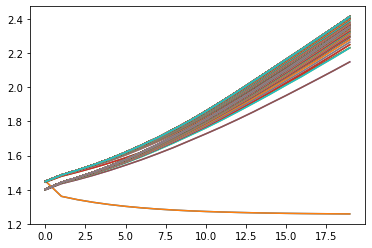

In [ ]:
umodel = train_model(100) # the net

In [ ]:
#@title for cifar eva
umodel = UNet().to(device)
umodel.load_state_dict(torch.load("/content/drive/MyDrive/FYP/u1.1019291394865938.pt"))
umodel.eval()

# Deprecated Ensemble

Epoch 1: 82s val loss 0.545873216651514
Epoch 2: 81s val loss 0.4500038602728724
Epoch 3: 82s val loss 0.36765514132107924
Epoch 4: 81s val loss 0.2929672575142115
Epoch 5: 81s val loss 0.22693972741410603
Epoch 6: 81s val loss 0.18043110352248512
Epoch 7: 81s val loss 0.1576804709897178
Epoch 8: 81s val loss 0.14827313028918898
Epoch 9: 80s val loss 0.14399643338197404
Epoch 10: 81s val loss 0.1412104826178529


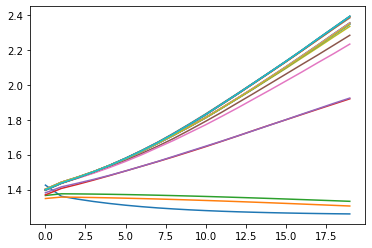

In [ ]:
umodel = train_model(10) # the net

In [ ]:
def lbl_model(loader):
	lbl = []
	rand = random.random()
	a = rand
	b = 1-a
	if rand<thr:
		a = 1-a
		b = 1-b

	saliency = IntegratedGradients(fnn)
	lrpa = LRP(fnn)
	for data, target in loader:
	  data, target = data.to(device), target.to(device)
	  data = data.view(data.size(0), 28 * 28)
	  s = saliency.attribute(data, target=target)
	  l = lrpa.attribute(data, target=target)
	  with torch.no_grad():
    	lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

    lbl = torch.FloatTensor(lbl)

    return lbl


In [ ]:
# ensemble
models = [umodel, dmodel, lbl_model]

#pred = [mod(data) for mod in models]

from functorch import comine_state_for_ensemble

emodel, params, buffers = comine_state_for_ensemble(models)
[p.requires_grad() for p in params];

from functorch import vmp


for data, target in train_loader:
	data, targte = data.to(device), target.to(device)
	pred_vmp = vmap(emodel, in_dims=(0,0,None))(params, buffers, data)

# Eva

In [ ]:
umodel.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:  
    data = data.to(device)
    target = target.to(device)   
    # self loss itr 2
    mask = umodel(data)

print(mask.shape)
print(mask[0])

torch.Size([512, 1, 28, 28])
tensor([[[0.3778, 0.7382, 0.8701, 0.8566, 0.9264, 0.8667, 0.9174, 0.8919,
          0.9122, 0.9380, 0.9522, 0.8474, 0.9822, 0.9579, 0.9591, 0.8165,
          0.9419, 0.9491, 0.9370, 0.8303, 0.9107, 0.8445, 0.9764, 0.8244,
          0.7910, 0.8179, 0.6974, 0.1905],
         [0.3308, 0.8468, 0.8584, 0.9634, 1.0294, 1.0418, 0.9648, 0.9886,
          0.9579, 0.9922, 0.9970, 0.9791, 0.9489, 0.9749, 0.9980, 0.9962,
          0.9834, 0.9764, 1.0007, 1.0130, 1.0132, 1.0156, 1.0676, 0.9796,
          1.0039, 0.9938, 0.9731, 0.6517],
         [0.3679, 0.8672, 0.8304, 1.1362, 1.0707, 0.9933, 1.0141, 1.0830,
          0.9892, 1.0404, 1.0434, 1.0835, 1.0467, 1.0766, 1.0303, 1.0526,
          1.0352, 1.0540, 1.0508, 1.0312, 0.9985, 1.0292, 1.0354, 1.0354,
          0.9771, 0.9958, 1.1338, 0.9855],
         [0.4379, 1.0407, 0.9597, 0.9900, 0.9784, 1.0290, 0.9344, 0.9736,
          0.9820, 1.0006, 1.0053, 1.0519, 0.9740, 1.0407, 1.0298, 1.0545,
          0.9815, 1.0069, 1.

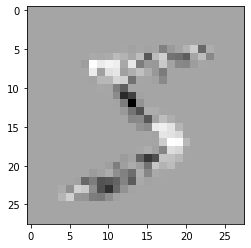

In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

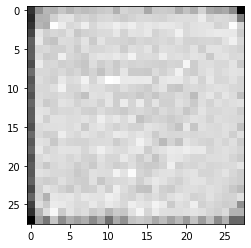

In [ ]:
plt.imshow(mask[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# Evaluate

In [ ]:
#@title save data txt
import numpy as np
np.savetxt('my_file.txt', lbl[0][0,:].cpu().detach().numpy())

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
	# print(X_pgd.shape)
	# region = Variable(region.data, requires_grad=True)
 
	if args.random:
		#noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device) 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			#print('m',model(X_pgd).shape)
			#print('y',y.shape)
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()
		#print('r', region.shape)
		# print(region.grad.data)

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	#print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	#if not bi % 200: plt.plot(st, lss)
	if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	plt.plot(st, lss)
	if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
def pgd_eval_adv_test(device, test_loader):

    fnn.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            print(batch_idx)
            data, target = data.to(device), target.to(device)

            data = data.view(data.size(0), 28 * 28)
            adv_data = pgd_whitebox0(batch_idx, fnn, data, target, device=device)

            output = fnn(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0
pgd time:  0.039702653884887695  s
0 misclassified: 1558
1
pgd time:  0.03870105743408203  s
1 misclassified: 1555
2
pgd time:  0.043703317642211914  s
2 misclassified: 1540
3
pgd time:  0.04518604278564453  s
3 misclassified: 1599
4
pgd time:  0.06406831741333008  s
4 misclassified: 1572
5
pgd time:  0.042890310287475586  s
5 misclassified: 1534
6
pgd time:  0.043582916259765625  s
6 misclassified: 1557
7
pgd time:  0.043064117431640625  s
7 misclassified: 1620
8
pgd time:  0.048494815826416016  s
8 misclassified: 1638
9
pgd time:  0.05064892768859863  s
9 misclassified: 1545
10
pgd time:  0.040532827377319336  s
10 misclassified: 1577
11
pgd time:  0.03865814208984375  s
11 misclassified: 1549
12
pgd time:  0.03943300247192383  s
12 misclassified: 1596
13
pgd time:  0.03981590270996094  s
13 misclassified: 1587
14
pgd time:  0.04392576217651367  s
14 misclassified: 1630
15
pgd time:  0.04693460464477539  s
15 misclassified: 1655
16
pgd time:  0.03902888298034668  s
16 misclassified

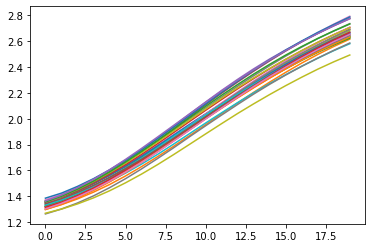

In [ ]:
advloss, advacc = pgd_eval_adv_test(device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

0
pgd time:  0.2462174892425537  s
0 misclassified: 386
1
pgd time:  0.24896788597106934  s
1 misclassified: 385
2
pgd time:  0.20292186737060547  s
2 misclassified: 407
3
pgd time:  0.30037498474121094  s
3 misclassified: 387
4
pgd time:  0.18675947189331055  s
4 misclassified: 380
5
pgd time:  0.19283485412597656  s
5 misclassified: 383
6
pgd time:  0.4347810745239258  s
6 misclassified: 402
7
pgd time:  0.30568933486938477  s
7 misclassified: 389
8
pgd time:  0.4093749523162842  s
8 misclassified: 394
9
pgd time:  0.2839498519897461  s
9 misclassified: 400
10
pgd time:  0.3872349262237549  s
10 misclassified: 371
11
pgd time:  0.27918362617492676  s
11 misclassified: 380
12
pgd time:  0.31569981575012207  s
12 misclassified: 373
13
pgd time:  0.28865504264831543  s
13 misclassified: 408
14
pgd time:  0.2812986373901367  s
14 misclassified: 420
15
pgd time:  0.2931985855102539  s
15 misclassified: 397
16
pgd time:  0.1749260425567627  s
16 misclassified: 403
17
pgd time:  0.288674354

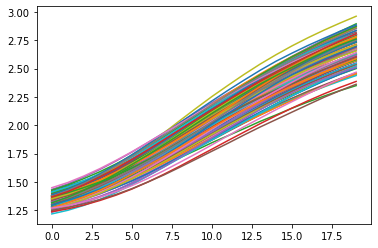

In [ ]:
advloss, advacc = pgd_eval_adv_test(device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
def lbl_eval_adv_test(mask, device, test_loader):

    fnn.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            data = data.view(data.size(0), 28*28)
            #print(data.dtype, mask[batch_idx].dtype)
            adv_data = pgd_whitebox(batch_idx, fnn, data, mask[batch_idx].to(torch.float32), target, device=device)

            #adv_data = adv_data.view(adv_data.size(0), 28*28)
            output = fnn(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

pgd time:  0.07797098159790039  s
0 misclassified: 1466
pgd time:  0.02701258659362793  s
1 misclassified: 1466
pgd time:  0.029230833053588867  s
2 misclassified: 1463
pgd time:  0.029248952865600586  s
3 misclassified: 1522
pgd time:  0.030928611755371094  s
4 misclassified: 1486
pgd time:  0.029732704162597656  s
5 misclassified: 1466
pgd time:  0.061003923416137695  s
6 misclassified: 1480
pgd time:  0.026134967803955078  s
7 misclassified: 1530
pgd time:  0.02666449546813965  s
8 misclassified: 1552
pgd time:  0.02785205841064453  s
9 misclassified: 1472
pgd time:  0.030310869216918945  s
10 misclassified: 1498
pgd time:  0.026751279830932617  s
11 misclassified: 1471
pgd time:  0.02987074851989746  s
12 misclassified: 1520
pgd time:  0.027230262756347656  s
13 misclassified: 1509
pgd time:  0.02803635597229004  s
14 misclassified: 1561
pgd time:  0.030416250228881836  s
15 misclassified: 1566
pgd time:  0.02916550636291504  s
16 misclassified: 1492
pgd time:  0.038625240325927734

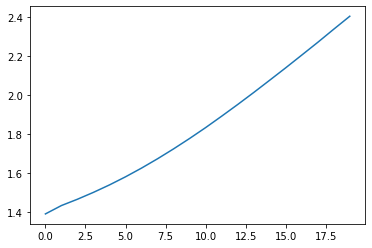

In [ ]:
advloss, advacc = lbl_eval_adv_test(lbl, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

pgd time:  0.17927312850952148  s
0 misclassified: 361
pgd time:  0.17809700965881348  s
1 misclassified: 361
pgd time:  0.1947014331817627  s
2 misclassified: 381
pgd time:  0.32995033264160156  s
3 misclassified: 363
pgd time:  0.1590890884399414  s
4 misclassified: 353
pgd time:  0.6252410411834717  s
5 misclassified: 365
pgd time:  0.18733525276184082  s
6 misclassified: 381
pgd time:  0.620206356048584  s
7 misclassified: 367
pgd time:  0.2504768371582031  s
8 misclassified: 364
pgd time:  0.2248849868774414  s
9 misclassified: 380
pgd time:  0.17609834671020508  s
10 misclassified: 355
pgd time:  0.1588764190673828  s
11 misclassified: 364
pgd time:  0.3253159523010254  s
12 misclassified: 360
pgd time:  0.18574190139770508  s
13 misclassified: 385
pgd time:  0.1583268642425537  s
14 misclassified: 401
pgd time:  0.3214449882507324  s
15 misclassified: 376
pgd time:  0.18197250366210938  s
16 misclassified: 385
pgd time:  0.16118955612182617  s
17 misclassified: 380
pgd time:  0.

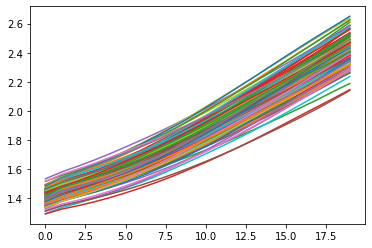

In [ ]:
advloss, advacc = lbl_eval_adv_test(lbl, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

pgd time:  0.06381773948669434  s
0 misclassified: 462
pgd time:  0.03733181953430176  s
1 misclassified: 462


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pgd time:  0.03477358818054199  s
2 misclassified: 464
pgd time:  0.03257393836975098  s
3 misclassified: 466
pgd time:  0.03131270408630371  s
4 misclassified: 462
pgd time:  0.029393911361694336  s
5 misclassified: 460
pgd time:  0.030286550521850586  s
6 misclassified: 466
pgd time:  0.030926942825317383  s
7 misclassified: 463
pgd time:  0.04280805587768555  s
8 misclassified: 460
pgd time:  0.032846927642822266  s
9 misclassified: 459


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pgd time:  0.03227996826171875  s
10 misclassified: 448
pgd time:  0.036864280700683594  s
11 misclassified: 463
pgd time:  0.03539013862609863  s
12 misclassified: 465
pgd time:  0.03440713882446289  s
13 misclassified: 454


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pgd time:  0.037693023681640625  s
14 misclassified: 464
pgd time:  0.0398554801940918  s
15 misclassified: 451
pgd time:  0.04202389717102051  s
16 misclassified: 468
pgd time:  0.030904054641723633  s
17 misclassified: 458
pgd time:  0.026644468307495117  s
18 misclassified: 461
pgd time:  0.060543060302734375  s
19 misclassified: 453
pgd time:  0.03901267051696777  s
20 misclassified: 463
pgd time:  0.025564908981323242  s
21 misclassified: 464
pgd time:  0.024001598358154297  s
22 misclassified: 457
pgd time:  0.03016519546508789  s
23 misclassified: 457
pgd time:  0.02680206298828125  s
24 misclassified: 458
pgd time:  0.026337385177612305  s
25 misclassified: 461
pgd time:  0.025687217712402344  s
26 misclassified: 465
pgd time:  0.03765368461608887  s
27 misclassified: 457
pgd time:  0.026248455047607422  s
28 misclassified: 468
pgd time:  0.02653026580810547  s
29 misclassified: 465
pgd time:  0.028026103973388672  s
30 misclassified: 452
pgd time:  0.029085874557495117  s
31 m

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pgd time:  0.03285717964172363  s
44 misclassified: 459
pgd time:  0.02756047248840332  s
45 misclassified: 467
pgd time:  0.027826309204101562  s
46 misclassified: 467
pgd time:  0.027500391006469727  s
47 misclassified: 467
pgd time:  0.025633573532104492  s
48 misclassified: 460
pgd time:  0.029140949249267578  s
49 misclassified: 468
pgd time:  0.027532100677490234  s
50 misclassified: 465
pgd time:  0.02764749526977539  s
51 misclassified: 463
pgd time:  0.03421664237976074  s
52 misclassified: 468
pgd time:  0.027976036071777344  s
53 misclassified: 455
pgd time:  0.026371002197265625  s
54 misclassified: 466
pgd time:  0.026717185974121094  s
55 misclassified: 459
pgd time:  0.028954029083251953  s
56 misclassified: 462
pgd time:  0.06338214874267578  s
57 misclassified: 448
pgd time:  0.04919886589050293  s
58 misclassified: 461


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pgd time:  0.03178262710571289  s
59 misclassified: 458
pgd time:  0.0265042781829834  s
60 misclassified: 466
pgd time:  0.02858710289001465  s
61 misclassified: 466
pgd time:  0.025966882705688477  s
62 misclassified: 473
pgd time:  0.026026248931884766  s
63 misclassified: 469
pgd time:  0.025904417037963867  s
64 misclassified: 457
pgd time:  0.02963113784790039  s
65 misclassified: 462
pgd time:  0.02533435821533203  s
66 misclassified: 460
pgd time:  0.025783061981201172  s
67 misclassified: 460
pgd time:  0.03320455551147461  s
68 misclassified: 470
pgd time:  0.02588510513305664  s
69 misclassified: 457
pgd time:  0.026669979095458984  s
70 misclassified: 464
pgd time:  0.027004480361938477  s
71 misclassified: 461
pgd time:  0.031171560287475586  s
72 misclassified: 476
pgd time:  0.02698993682861328  s
73 misclassified: 462
pgd time:  0.06284427642822266  s
74 misclassified: 455
pgd time:  0.027059316635131836  s
75 misclassified: 461
pgd time:  0.02602696418762207  s
76 misc

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:


pgd time:  0.026917695999145508  s
84 misclassified: 464
pgd time:  0.027695655822753906  s
85 misclassified: 471
pgd time:  0.026981353759765625  s
86 

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


misclassified: 467
pgd time:  0.025007247924804688  s
87 misclassified: 456
pgd time:  0.04107260704040527  s
88 misclassified: 456
pgd time:  0.026750802993774414  s
89 misclassified: 467
pgd time:  0.02692866325378418  s
90 misclassified: 467
pgd time:  0.02613091468811035  s
91 misclassified: 452
pgd time:  0.026398181915283203  s
92 misclassified: 458
pgd time:  0.02525472640991211  s
93 misclassified: 465
pgd time:  0.026061058044433594  s
94 misclassified: 453
pgd time:  0.030318260192871094  s
95 misclassified: 468
pgd time:  0.027737855911254883  s
96 misclassified: 453
pgd time:  0.027032852172851562  s
97 misclassified: 463
pgd time:  0.02711963653564453  s
98 misclassified: 456
pgd time:  0.02706456184387207  s
99 misclassified: 462
pgd time:  0.026016712188720703  s
100 misclassified: 462
pgd time:  0.06537127494812012  s
101 misclassified: 458


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:


pgd time:  0.02699446678161621  s
102 misclassified: 461
pgd time:  0.025112628936767578  s
103 misclassified: 466
pgd time:  0.02709674835205078  s
104 misclassified: 456
pgd time:  0.02646470069885254  s
105 misclassified: 466
pgd time:  0.03219437599182129  s
106 misclassified: 462
pgd time:  0.027149438858032227  s
107 misclassified: 455
pgd time:  0.045382022857666016  s
108 misclassified: 462
pgd time:  0.048876047134399414  s
109 misclassified: 471
pgd time:  0.032427310943603516  s
110 misclassified: 456
pgd time:  0.034531354904174805  s
111 misclassified: 462
pgd time:  0.03169703483581543  s
112 misclassified: 454
pgd time:  0.03205609321594238  s
113 misclassified: 465
pgd time:  0.03717613220214844  s
114 misclassified: 460
pgd time:  0.032308340072631836  s
115 misclassified: 464
pgd time:  0.04558420181274414  s
116 misclassified: 463
test_loss: 2.2974, test_acc: 9.89%, 

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:27: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  def legacy_get_string(size_average: Optional[bool], reduce: Optional[bool], emit_warning: bool = True) -> str:


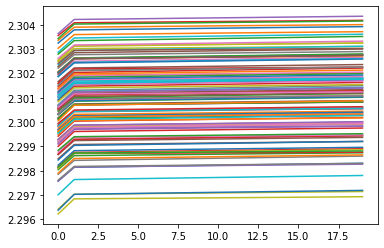

In [ ]:
#@title GB
advloss, advacc = lbl_eval_adv_test(mask, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

# Model eva

In [ ]:
#@title query-efficient
#data = data.view(data.size(0), 28*28)
buf = []
umodel.eval()
with torch.no_grad():
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    buf.append(umodel(data))

In [ ]:
#@title TODO:重新做图评估
print(buf[0].shape)

torch.Size([512, 1, 28, 28])


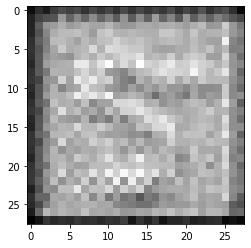

In [ ]:
plt.imshow(buf[1][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
print(torch.max(buf[1][0,:].cpu()))
print(torch.min(buf[1][0,:].cpu()))

tensor(1.2269)
tensor(0.5578)


In [ ]:
def eval_adv_test(model, device, test_loader):

    model.eval().to(device)
    fnn.eval().to(device)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            buf = model(data)
            adv = pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), buf.view(buf.size(0), 28*28), target, device=device)
            output = fnn(adv)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0 misclassified: 361
1 misclassified: 361
2 misclassified: 381
3 misclassified: 363
4 misclassified: 353
5 misclassified: 365
6 misclassified: 381
7 misclassified: 367
8 misclassified: 364
9 misclassified: 380
10 misclassified: 355
11 misclassified: 364
12 misclassified: 360
13 misclassified: 385
14 misclassified: 401
15 misclassified: 376
16 misclassified: 385
17 misclassified: 380
18 misclassified: 382
19 misclassified: 339
20 misclassified: 365
21 misclassified: 372
22 misclassified: 368
23 misclassified: 361
24 misclassified: 381
25 misclassified: 368
26 misclassified: 356
27 misclassified: 375
28 misclassified: 410
29 misclassified: 373
30 misclassified: 377
31 misclassified: 370
32 misclassified: 386
33 misclassified: 371
34 misclassified: 411
35 misclassified: 384
36 misclassified: 374
37 misclassified: 376
38 misclassified: 343
39 misclassified: 379
40 misclassified: 374
41 misclassified: 373
42 misclassified: 360
43 misclassified: 391
44 misclassified: 349
45 misclassified: 36

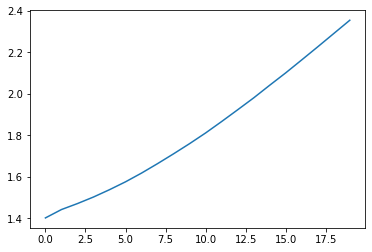

In [ ]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = eval_adv_test(model, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

pgd time:  0.24507546424865723  s
0 misclassified: 360
pgd time:  0.2409381866455078  s
1 misclassified: 361
pgd time:  0.3740992546081543  s
2 misclassified: 381
pgd time:  0.32465696334838867  s
3 misclassified: 363
pgd time:  0.2142167091369629  s
4 misclassified: 353
pgd time:  0.2133333683013916  s
5 misclassified: 365
pgd time:  0.21207332611083984  s
6 misclassified: 381
pgd time:  0.2106180191040039  s
7 misclassified: 367
pgd time:  0.21405625343322754  s
8 misclassified: 364
pgd time:  0.21881484985351562  s
9 misclassified: 380
pgd time:  0.2319011688232422  s
10 misclassified: 355
pgd time:  0.20924925804138184  s
11 misclassified: 364
pgd time:  0.2129068374633789  s
12 misclassified: 360
pgd time:  0.34556031227111816  s
13 misclassified: 385
pgd time:  0.28491806983947754  s
14 misclassified: 401
pgd time:  0.20582032203674316  s
15 misclassified: 376
pgd time:  0.22446632385253906  s
16 misclassified: 385
pgd time:  0.21152091026306152  s
17 misclassified: 381
pgd time:

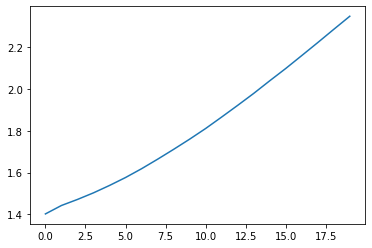

In [ ]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = eval_adv_test(model, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

## eva kernel

In [ ]:
!pip install --quiet torchshow

In [ ]:
import torchshow as ts

In [ ]:
for name, layer in umodel.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer, layer.weight)
    ts.save(layer.weight)

encoder.enc_blocks.0.conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Parameter containing:
tensor([[[[ 8.9971e-03,  1.6980e-02,  3.0555e-03],
          [-2.2722e-03,  5.8265e-03,  1.2713e-02],
          [ 1.9273e-02, -2.2611e-02,  9.8141e-04]],

         [[-3.5624e-03,  1.2339e-02,  1.6382e-02],
          [ 4.7598e-03,  1.4035e-03,  2.2452e-03],
          [ 1.0035e-02, -1.6970e-02,  5.9446e-03]],

         [[ 5.7371e-03, -6.0072e-03,  2.4123e-03],
          [ 2.3917e-03, -6.8665e-05,  3.4408e-03],
          [-8.2148e-03,  5.0208e-03,  1.3612e-02]]],


        [[[ 1.2052e-02,  1.7957e-02,  1.1538e-02],
          [-1.4766e-02,  4.9562e-03, -8.9798e-03],
          [-8.8300e-03, -9.2030e-03, -1.9798e-03]],

         [[-4.5602e-03, -1.0022e-02, -8.5702e-03],
          [ 3.5215e-03, -1.3452e-02,  8.2336e-03],
          [-3.1330e-03, -7.6561e-03,  4.0834e-03]],

         [[ 1.6485e-02, -6.8018e-03,  8.6142e-03],
          [ 1.9739e-02, -9.1693e-03,  5.2636e-03],
       

In [ ]:
!zip -r ukts.zip /content/_torchshow